# Análisis Exploratorio de Datos (EDA) - Tabla: usuarios

## Objetivo

Realizar un análisis exploratorio completo de la tabla `usuarios` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [71]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [72]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [73]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'usuarios'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: usuarios")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: usuarios
   column_name                   data_type  character_maximum_length is_nullable                               column_default
    usuario_id                     integer                       NaN          NO nextval('usuarios_usuario_id_seq'::regclass)
        nombre           character varying                     100.0          NO                                         None
      apellido           character varying                     100.0          NO                                         None
           dni           character varying                      20.0          NO                                         None
         email           character varying                     255.0          NO                                         None
    contraseña           character varying                     255.0          NO                                         None
fecha_registro timestamp without time zone                       NaN         YES     

### 2.2. Restricciones y Claves (Constraints)


In [74]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'usuarios'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: usuarios")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")


RESTRICCIONES Y CLAVES DE LA TABLA: usuarios
   constraint_name constraint_type column_name foreign_table_name foreign_column_name
     usuarios_pkey     PRIMARY KEY  usuario_id           usuarios          usuario_id
  usuarios_dni_key          UNIQUE         dni           usuarios                 dni
usuarios_email_key          UNIQUE       email           usuarios               email


### 2.3. Estadísticas Básicas con SQL


In [75]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT usuario_id) as usuarios_unicos,
    COUNT(DISTINCT dni) as dnis_unicos,
    COUNT(DISTINCT email) as emails_unicos,
    MIN(fecha_registro) as fecha_registro_min,
    MAX(fecha_registro) as fecha_registro_max,
    MAX(fecha_registro) - MIN(fecha_registro) as rango_fechas
FROM usuarios;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: usuarios")
print("=" * 80)
print(df_stats.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: usuarios
 total_registros  usuarios_unicos  dnis_unicos  emails_unicos         fecha_registro_min         fecha_registro_max rango_fechas
            1000             1000         1000           1000 2025-11-13 01:35:44.037255 2025-11-13 01:35:44.037255       0 days


## 3. Análisis Exploratorio con Python (SQLAlchemy)


In [76]:
# Cargar la tabla completa en un DataFrame
query_usuarios = "SELECT * FROM usuarios;"
df_usuarios = pd.read_sql(query_usuarios, engine)

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_usuarios.shape}")
print(f"Columnas: {list(df_usuarios.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_usuarios.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (1000, 7)
Columnas: ['usuario_id', 'nombre', 'apellido', 'dni', 'email', 'contraseña', 'fecha_registro']

Primeras 10 filas:
   usuario_id        nombre   apellido       dni  \
0           1       Encarna    Donaire  49877134   
1           2  Jose Ignacio    Canales  98778810   
2           3          José  Sebastián  80095714   
3           4      Priscila      Vilar  94128750   
4           5      Epifanio       Ríos  62958342   
5           6      Cipriano     Sastre  49889941   
6           7      Gerónimo     Alcalá  55549753   
7           8        Odalis    Estévez  93023722   
8           9         Clara      Prada  67127313   
9          10       Azahara     Espada  38665213   

                              email     contraseña             fecha_registro  
0       encarna.donaire1@correo.com  Contraseña123 2025-11-13 01:35:44.037255  
1  jose ignacio.canales2@correo.com  Contraseña123 2025-11-13 01:35:44.037255  
2        josé.seb

### 3.1. Información General del DataFrame


In [77]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_usuarios.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_usuarios.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_usuarios.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   usuario_id      1000 non-null   int64         
 1   nombre          1000 non-null   object        
 2   apellido        1000 non-null   object        
 3   dni             1000 non-null   object        
 4   email           1000 non-null   object        
 5   contraseña      1000 non-null   object        
 6   fecha_registro  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 54.8+ KB

TIPOS DE DATOS POR COLUMNA
usuario_id                 int64
nombre                    object
apellido                  object
dni                       object
email                     object
contraseña                object
fecha_registro    datetime64[ns]
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
         usuario_id   n

### 3.2. Detección de Valores Nulos


In [78]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_usuarios.isnull().sum()
porcentaje_nulos = (df_usuarios.isnull().sum() / len(df_usuarios)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_usuarios.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")


ANÁLISIS DE VALORES NULOS
       Columna  Cantidad_Nulos  Porcentaje_Nulos
    usuario_id               0               0.0
        nombre               0               0.0
      apellido               0               0.0
           dni               0               0.0
         email               0               0.0
    contraseña               0               0.0
fecha_registro               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [79]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_usuarios.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por usuario_id (clave primaria)
duplicados_usuario_id = df_usuarios['usuario_id'].duplicated().sum()
print(f"Duplicados en usuario_id (PK): {duplicados_usuario_id}")

# Duplicados por DNI (debe ser único)
duplicados_dni = df_usuarios['dni'].duplicated().sum()
print(f"Duplicados en DNI (debe ser único): {duplicados_dni}")

# Duplicados por email (debe ser único)
duplicados_email = df_usuarios['email'].duplicated().sum()
print(f"Duplicados en email (debe ser único): {duplicados_email}")

# Mostrar duplicados si existen
if duplicados_dni > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron DNIs duplicados:")
    dnis_duplicados = df_usuarios[df_usuarios['dni'].duplicated(keep=False)]
    print(dnis_duplicados[['usuario_id', 'nombre', 'apellido', 'dni', 'email']].sort_values('dni'))

if duplicados_email > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron emails duplicados:")
    emails_duplicados = df_usuarios[df_usuarios['email'].duplicated(keep=False)]
    print(emails_duplicados[['usuario_id', 'nombre', 'apellido', 'dni', 'email']].sort_values('email'))

if duplicados_completos == 0 and duplicados_usuario_id == 0 and duplicados_dni == 0 and duplicados_email == 0:
    print("\n✓ No se encontraron duplicados en la tabla.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en usuario_id (PK): 0
Duplicados en DNI (debe ser único): 0
Duplicados en email (debe ser único): 0

✓ No se encontraron duplicados en la tabla.


### 3.4. Análisis de Campos de Texto


In [80]:
# Análisis de campos de texto
print("=" * 80)
print("ANÁLISIS DE CAMPOS DE TEXTO")
print("=" * 80)

campos_texto = ['nombre', 'apellido', 'dni', 'email', 'contraseña']

for campo in campos_texto:
    print(f"\n--- Análisis de '{campo}' ---")
    print(f"Longitud mínima: {df_usuarios[campo].str.len().min()}")
    print(f"Longitud máxima: {df_usuarios[campo].str.len().max()}")
    print(f"Longitud promedio: {df_usuarios[campo].str.len().mean():.2f}")
    print(f"Valores únicos: {df_usuarios[campo].nunique()}")
    
    # Valores vacíos o solo espacios
    valores_vacios = (df_usuarios[campo].str.strip() == '').sum()
    if valores_vacios > 0:
        print(f"⚠ Valores vacíos o solo espacios: {valores_vacios}")
    
    # Mostrar algunos ejemplos
    print(f"Ejemplos (primeros 5):")
    print(df_usuarios[campo].head().tolist())


ANÁLISIS DE CAMPOS DE TEXTO

--- Análisis de 'nombre' ---
Longitud mínima: 3
Longitud máxima: 16
Longitud promedio: 6.75
Valores únicos: 615
Ejemplos (primeros 5):
['Encarna', 'Jose Ignacio', 'José', 'Priscila', 'Epifanio']

--- Análisis de 'apellido' ---
Longitud mínima: 2
Longitud máxima: 11
Longitud promedio: 6.22
Valores únicos: 664
Ejemplos (primeros 5):
['Donaire', 'Canales', 'Sebastián', 'Vilar', 'Ríos']

--- Análisis de 'dni' ---
Longitud mínima: 8
Longitud máxima: 8
Longitud promedio: 8.00
Valores únicos: 1000
Ejemplos (primeros 5):
['49877134', '98778810', '80095714', '94128750', '62958342']

--- Análisis de 'email' ---
Longitud mínima: 22
Longitud máxima: 39
Longitud promedio: 27.86
Valores únicos: 1000
Ejemplos (primeros 5):
['encarna.donaire1@correo.com', 'jose ignacio.canales2@correo.com', 'josé.sebastián3@correo.com', 'priscila.vilar4@correo.com', 'epifanio.ríos5@correo.com']

--- Análisis de 'contraseña' ---
Longitud mínima: 13
Longitud máxima: 13
Longitud promedio: 13.

### 3.5. Validación de Formato de DNI


In [81]:
# Validación de formato DNI
print("=" * 80)
print("VALIDACIÓN DE FORMATO DNI")
print("=" * 80)

# DNI típicamente tiene 8 dígitos en muchos países
# Verificar si todos son numéricos
dni_numerico = df_usuarios['dni'].str.isdigit()
dni_no_numerico = df_usuarios[~dni_numerico]

print(f"DNIs que son completamente numéricos: {dni_numerico.sum()}")
print(f"DNIs que NO son completamente numéricos: {len(dni_no_numerico)}")

if len(dni_no_numerico) > 0:
    print("\n⚠ DNIs con formato no numérico:")
    print(dni_no_numerico[['usuario_id', 'nombre', 'apellido', 'dni']].head(10))

# Análisis de longitud de DNI
longitudes_dni = df_usuarios['dni'].str.len()
print(f"\nLongitud de DNI:")
print(f"  Mínima: {longitudes_dni.min()}")
print(f"  Máxima: {longitudes_dni.max()}")
print(f"  Promedio: {longitudes_dni.mean():.2f}")
print(f"  Distribución de longitudes:")
print(longitudes_dni.value_counts().sort_index())

# Verificar DNIs con longitud atípica
dni_atipicos = df_usuarios[(longitudes_dni < 7) | (longitudes_dni > 10)]
if len(dni_atipicos) > 0:
    print(f"\n⚠ DNIs con longitud atípica (< 7 o > 10): {len(dni_atipicos)}")
    print(dni_atipicos[['usuario_id', 'nombre', 'apellido', 'dni']].head(10))


VALIDACIÓN DE FORMATO DNI
DNIs que son completamente numéricos: 1000
DNIs que NO son completamente numéricos: 0

Longitud de DNI:
  Mínima: 8
  Máxima: 8
  Promedio: 8.00
  Distribución de longitudes:
dni
8    1000
Name: count, dtype: int64


### 3.6. Validación de Formato de Email


In [82]:
# Validación de formato de email
print("=" * 80)
print("VALIDACIÓN DE FORMATO EMAIL")
print("=" * 80)

# Patrón básico de validación de email
patron_email = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
emails_validos = df_usuarios['email'].str.match(patron_email, na=False)
emails_invalidos = df_usuarios[~emails_validos]

print(f"Emails con formato válido: {emails_validos.sum()}")
print(f"Emails con formato inválido: {len(emails_invalidos)}")

# Análisis detallado de formatos inadecuados
print("\n" + "=" * 80)
print("ANÁLISIS DETALLADO DE FORMATOS INADECUADOS EN EMAILS")
print("=" * 80)

formatos_inadecuados = []

# 1. Emails con espacios
emails_con_espacios = df_usuarios[df_usuarios['email'].str.contains(' ', na=False)]
if len(emails_con_espacios) > 0:
    formatos_inadecuados.append({
        'Tipo de Problema': 'Espacios en el email',
        'Cantidad': len(emails_con_espacios),
        'Descripción': 'Emails que contienen uno o más espacios en blanco',
        'Ejemplos': emails_con_espacios['email'].head(5).tolist()
    })

# 2. Emails con caracteres acentuados
emails_con_acentos = df_usuarios[df_usuarios['email'].str.contains(r'[áéíóúñÁÉÍÓÚÑ]', na=False, regex=True)]
if len(emails_con_acentos) > 0:
    formatos_inadecuados.append({
        'Tipo de Problema': 'Caracteres acentuados',
        'Cantidad': len(emails_con_acentos),
        'Descripción': 'Emails que contienen letras con acentos (á, é, í, ó, ú, ñ)',
        'Ejemplos': emails_con_acentos['email'].head(5).tolist()
    })

# 3. Emails con caracteres especiales no permitidos
caracteres_especiales = r'[<>"\'\\]'
emails_especiales = df_usuarios[df_usuarios['email'].str.contains(caracteres_especiales, na=False, regex=True)]
if len(emails_especiales) > 0:
    formatos_inadecuados.append({
        'Tipo de Problema': 'Caracteres especiales no permitidos',
        'Cantidad': len(emails_especiales),
        'Descripción': 'Emails que contienen caracteres como <, >, ", \', \\',
        'Ejemplos': emails_especiales['email'].head(5).tolist()
    })

# 4. Emails sin @
emails_sin_arroba = df_usuarios[~df_usuarios['email'].str.contains('@', na=False)]
if len(emails_sin_arroba) > 0:
    formatos_inadecuados.append({
        'Tipo de Problema': 'Falta símbolo @',
        'Cantidad': len(emails_sin_arroba),
        'Descripción': 'Emails que no contienen el símbolo @',
        'Ejemplos': emails_sin_arroba['email'].head(5).tolist()
    })

# 5. Emails sin dominio válido
emails_sin_dominio = df_usuarios[~df_usuarios['email'].str.contains(r'@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', na=False, regex=True)]
if len(emails_sin_dominio) > 0:
    formatos_inadecuados.append({
        'Tipo de Problema': 'Dominio inválido o faltante',
        'Cantidad': len(emails_sin_dominio),
        'Descripción': 'Emails que no tienen un dominio válido después del @',
        'Ejemplos': emails_sin_dominio['email'].head(5).tolist()
    })

# Mostrar resumen de formatos inadecuados
if len(formatos_inadecuados) > 0:
    print("\nRESUMEN DE FORMATOS INADECUADOS DETECTADOS:")
    print("-" * 80)
    for i, problema in enumerate(formatos_inadecuados, 1):
        print(f"\n{i}. {problema['Tipo de Problema']}")
        print(f"   Cantidad: {problema['Cantidad']} emails")
        print(f"   Descripción: {problema['Descripción']}")
        print(f"   Ejemplos:")
        for ejemplo in problema['Ejemplos']:
            print(f"      - {ejemplo}")
    
    # Crear DataFrame resumen
    df_formatos_inadecuados = pd.DataFrame([
        {
            'Tipo de Problema': p['Tipo de Problema'],
            'Cantidad': p['Cantidad'],
            'Descripción': p['Descripción']
        }
        for p in formatos_inadecuados
    ])
    
    print("\n" + "=" * 80)
    print("TABLA RESUMEN DE FORMATOS INADECUADOS")
    print("=" * 80)
    print(df_formatos_inadecuados.to_string(index=False))
else:
    print("\n✓ No se detectaron formatos inadecuados en los emails.")

# Mostrar todos los emails inválidos si existen
if len(emails_invalidos) > 0:
    print("\n" + "=" * 80)
    print("LISTA COMPLETA DE EMAILS CON FORMATO INVÁLIDO")
    print("=" * 80)
    print(f"Total: {len(emails_invalidos)} emails")
    print("\nPrimeros 20 ejemplos:")
    print(emails_invalidos[['usuario_id', 'nombre', 'apellido', 'email']].head(20).to_string(index=False))

# Análisis de dominios de email
dominios = df_usuarios['email'].str.split('@').str[1]
print(f"\n" + "=" * 80)
print("ANÁLISIS DE DOMINIOS")
print("=" * 80)
print(f"Dominios únicos: {dominios.nunique()}")
print(f"Top 10 dominios más frecuentes:")
print(dominios.value_counts().head(10))


VALIDACIÓN DE FORMATO EMAIL
Emails con formato válido: 621
Emails con formato inválido: 379

ANÁLISIS DETALLADO DE FORMATOS INADECUADOS EN EMAILS

RESUMEN DE FORMATOS INADECUADOS DETECTADOS:
--------------------------------------------------------------------------------

1. Espacios en el email
   Cantidad: 54 emails
   Descripción: Emails que contienen uno o más espacios en blanco
   Ejemplos:
      - jose ignacio.canales2@correo.com
      - jose francisco.vallés16@correo.com
      - juan francisco.vilanova33@correo.com
      - maría del carmen.baena42@correo.com
      - josé mari.dueñas52@correo.com

2. Caracteres acentuados
   Cantidad: 361 emails
   Descripción: Emails que contienen letras con acentos (á, é, í, ó, ú, ñ)
   Ejemplos:
      - josé.sebastián3@correo.com
      - epifanio.ríos5@correo.com
      - gerónimo.alcalá7@correo.com
      - odalis.estévez8@correo.com
      - eduardo.galán12@correo.com

TABLA RESUMEN DE FORMATOS INADECUADOS
     Tipo de Problema  Cantidad       

### 3.7. Análisis de Fechas de Registro


In [ ]:
# Análisis de fechas de registro
print("=" * 80)
print("ANÁLISIS DE FECHAS DE REGISTRO")
print("=" * 80)

# Convertir a datetime si no lo es
df_usuarios['fecha_registro'] = pd.to_datetime(df_usuarios['fecha_registro'])

print(f"Fecha de registro más antigua: {df_usuarios['fecha_registro'].min()}")
print(f"Fecha de registro más reciente: {df_usuarios['fecha_registro'].max()}")
print(f"Rango de fechas: {df_usuarios['fecha_registro'].max() - df_usuarios['fecha_registro'].min()}")

# Registros por año
df_usuarios['año_registro'] = df_usuarios['fecha_registro'].dt.year
df_usuarios['mes_registro'] = df_usuarios['fecha_registro'].dt.month
df_usuarios['dia_registro'] = df_usuarios['fecha_registro'].dt.day

print(f"\nRegistros por año:")
print(df_usuarios['año_registro'].value_counts().sort_index())

print(f"\nRegistros por mes (último año):")
print(df_usuarios[df_usuarios['año_registro'] == df_usuarios['año_registro'].max()]['mes_registro'].value_counts().sort_index())

# Detectar fechas atípicas (futuras o muy antiguas)
fecha_actual = datetime.now()
fechas_futuras = df_usuarios[df_usuarios['fecha_registro'] > fecha_actual]
fechas_muy_antiguas = df_usuarios[df_usuarios['fecha_registro'] < (fecha_actual - timedelta(days=365*10))]

if len(fechas_futuras) > 0:
    print(f"\n⚠ Fechas de registro futuras: {len(fechas_futuras)}")
    print(fechas_futuras[['usuario_id', 'nombre', 'apellido', 'fecha_registro']].head(10))

if len(fechas_muy_antiguas) > 0:
    print(f"\n⚠ Fechas de registro muy antiguas (>10 años): {len(fechas_muy_antiguas)}")
    print(fechas_muy_antiguas[['usuario_id', 'nombre', 'apellido', 'fecha_registro']].head(10))


ANÁLISIS DE FECHAS DE REGISTRO
Fecha de registro más antigua: 2025-11-13 01:35:44.037255
Fecha de registro más reciente: 2025-11-13 01:35:44.037255
Rango de fechas: 0 days 00:00:00

Registros por año:
año_registro
2025    1000
Name: count, dtype: int64

Registros por mes (último año):
mes_registro
11    1000
Name: count, dtype: int64


### 3.8. Detección de Valores Atípicos y Anomalías


In [84]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Nombres o apellidos muy cortos o muy largos
nombres_cortos = df_usuarios[df_usuarios['nombre'].str.len() < 2]
nombres_largos = df_usuarios[df_usuarios['nombre'].str.len() > 50]
apellidos_cortos = df_usuarios[df_usuarios['apellido'].str.len() < 2]
apellidos_largos = df_usuarios[df_usuarios['apellido'].str.len() > 50]

if len(nombres_cortos) > 0:
    print(f"⚠ Nombres muy cortos (< 2 caracteres): {len(nombres_cortos)}")
    anomalias.append(('Nombres muy cortos', len(nombres_cortos)))
    
if len(nombres_largos) > 0:
    print(f"⚠ Nombres muy largos (> 50 caracteres): {len(nombres_largos)}")
    anomalias.append(('Nombres muy largos', len(nombres_largos)))

if len(apellidos_cortos) > 0:
    print(f"⚠ Apellidos muy cortos (< 2 caracteres): {len(apellidos_cortos)}")
    anomalias.append(('Apellidos muy cortos', len(apellidos_cortos)))

if len(apellidos_largos) > 0:
    print(f"⚠ Apellidos muy largos (> 50 caracteres): {len(apellidos_largos)}")
    anomalias.append(('Apellidos muy largos', len(apellidos_largos)))

# 2. Contraseñas muy cortas (riesgo de seguridad)
contraseñas_cortas = df_usuarios[df_usuarios['contraseña'].str.len() < 6]
if len(contraseñas_cortas) > 0:
    print(f"⚠ Contraseñas muy cortas (< 6 caracteres): {len(contraseñas_cortas)}")
    anomalias.append(('Contraseñas muy cortas', len(contraseñas_cortas)))

# 3. Emails con caracteres especiales inusuales
emails_especiales = df_usuarios[df_usuarios['email'].str.contains(r'[<>"\'\\]', na=False)]
if len(emails_especiales) > 0:
    print(f"⚠ Emails con caracteres especiales inusuales: {len(emails_especiales)}")
    anomalias.append(('Emails con caracteres especiales', len(emails_especiales)))

# 4. Nombres o apellidos que parecen ser datos de prueba
patrones_prueba = ['test', 'prueba', 'admin', 'user', 'demo']
nombres_prueba = df_usuarios[
    df_usuarios['nombre'].str.lower().str.contains('|'.join(patrones_prueba), na=False) |
    df_usuarios['apellido'].str.lower().str.contains('|'.join(patrones_prueba), na=False)
]
if len(nombres_prueba) > 0:
    print(f"⚠ Nombres/apellidos que parecen ser de prueba: {len(nombres_prueba)}")
    anomalias.append(('Nombres de prueba', len(nombres_prueba)))

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS
⚠ Nombres/apellidos que parecen ser de prueba: 1

RESUMEN DE ANOMALÍAS DETECTADAS
 Tipo de Anomalía  Cantidad
Nombres de prueba         1


## 4. Identificación de Claves Primarias y Foráneas


In [85]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - usuario_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_usuarios['usuario_id'].min()} a {df_usuarios['usuario_id'].max()}")
print(f"   - Valores únicos: {df_usuarios['usuario_id'].nunique()}")
print(f"   - Total de registros: {len(df_usuarios)}")
print(f"   - ¿Sin duplicados?: {df_usuarios['usuario_id'].nunique() == len(df_usuarios)}")

# Claves únicas implícitas
print("\n2. CLAVES ÚNICAS:")
print("   - dni: UNIQUE constraint")
print(f"   - Valores únicos: {df_usuarios['dni'].nunique()}")
print(f"   - ¿Sin duplicados?: {df_usuarios['dni'].nunique() == len(df_usuarios)}")

print("   - email: UNIQUE constraint")
print(f"   - Valores únicos: {df_usuarios['email'].nunique()}")
print(f"   - ¿Sin duplicados?: {df_usuarios['email'].nunique() == len(df_usuarios)}")

# Claves foráneas que referencian esta tabla
print("\n3. CLAVES FORÁNEAS QUE REFERENCIAN ESTA TABLA:")
print("   (Verificar en otras tablas)")

tablas_relacionadas = ['ordenes', 'direcciones_envio', 'carrito', 'resenas_productos']
for tabla in tablas_relacionadas:
    try:
        query_fk = f"""
        SELECT COUNT(*) as total
        FROM {tabla}
        WHERE usuario_id IS NOT NULL;
        """
        df_fk = pd.read_sql(query_fk, engine)
        total_refs = df_fk['total'].iloc[0]
        
        # Verificar referencias huérfanas
        query_orphan = f"""
        SELECT COUNT(*) as huérfanas
        FROM {tabla} o
        LEFT JOIN usuarios u ON o.usuario_id = u.usuario_id
        WHERE o.usuario_id IS NOT NULL AND u.usuario_id IS NULL;
        """
        df_orphan = pd.read_sql(query_orphan, engine)
        huérfanas = df_orphan['huérfanas'].iloc[0]
        
        print(f"   - {tabla}.usuario_id: {total_refs} referencias")
        if huérfanas > 0:
            print(f"     ⚠ Referencias huérfanas: {huérfanas}")
    except Exception as e:
        print(f"   - {tabla}: No se pudo verificar ({str(e)})")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - usuario_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 1000
   - Valores únicos: 1000
   - Total de registros: 1000
   - ¿Sin duplicados?: True

2. CLAVES ÚNICAS:
   - dni: UNIQUE constraint
   - Valores únicos: 1000
   - ¿Sin duplicados?: True
   - email: UNIQUE constraint
   - Valores únicos: 1000
   - ¿Sin duplicados?: True

3. CLAVES FORÁNEAS QUE REFERENCIAN ESTA TABLA:
   (Verificar en otras tablas)
   - ordenes.usuario_id: 0 referencias
   - direcciones_envio.usuario_id: 0 referencias
   - carrito.usuario_id: 0 referencias
   - resenas_productos.usuario_id: 0 referencias


## 5. Análisis de Campos Semi-Estructurados


In [86]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['nombre', 'apellido', 'dni', 'email', 'contraseña']

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    json_pattern = r'\{.*\}|\[.*\]'
    tiene_json = df_usuarios[campo].str.contains(json_pattern, na=False, regex=True).sum()
    if tiene_json > 0:
        print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
        json_encontrado = True
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    for delim in delimitadores:
        tiene_delim = df_usuarios[campo].str.contains(delim, na=False, regex=False).sum()
        if tiene_delim > 0:
            print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
            delimitadores_encontrados = True
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores")

# 3. Buscar campos con múltiples valores concatenados
print("\n3. Campos con múltiples valores concatenados:")
# Por ejemplo, nombres compuestos que podrían estar mal estructurados
nombres_compuestos = df_usuarios[df_usuarios['nombre'].str.contains(' ', na=False)]
if len(nombres_compuestos) > 0:
    print(f"   - Nombres con espacios (posibles nombres compuestos): {len(nombres_compuestos)}")
    print(f"     Ejemplos:")
    print(nombres_compuestos[['nombre', 'apellido']].head(5).to_string(index=False))

apellidos_compuestos = df_usuarios[df_usuarios['apellido'].str.contains(' ', na=False)]
if len(apellidos_compuestos) > 0:
    print(f"   - Apellidos con espacios (posibles apellidos compuestos): {len(apellidos_compuestos)}")
    print(f"     Ejemplos:")
    print(apellidos_compuestos[['nombre', 'apellido']].head(5).to_string(index=False))

# 4. Análisis de email (puede contener información estructurada)
print("\n4. Análisis de estructura de email:")
# Los emails tienen estructura: usuario@dominio.extension
df_usuarios['email_usuario'] = df_usuarios['email'].str.split('@').str[0]
df_usuarios['email_dominio'] = df_usuarios['email'].str.split('@').str[1]

print(f"   - Prefijos de email únicos: {df_usuarios['email_usuario'].nunique()}")
print(f"   - Dominios únicos: {df_usuarios['email_dominio'].nunique()}")

# Verificar si el prefijo del email coincide con nombre.apellido
print("\n5. Coherencia entre nombre/apellido y email:")
# Extraer nombre y apellido del email
emails_con_coherencia = 0
for idx, row in df_usuarios.iterrows():
    email_prefijo = row['email_usuario'].lower()
    nombre_lower = row['nombre'].lower().replace(' ', '')
    apellido_lower = row['apellido'].lower().replace(' ', '')
    
    # Verificar si el email contiene nombre y apellido
    if nombre_lower in email_prefijo and apellido_lower in email_prefijo:
        emails_con_coherencia += 1

print(f"   - Emails que contienen nombre y apellido: {emails_con_coherencia} ({emails_con_coherencia/len(df_usuarios)*100:.1f}%)")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'usuarios' no contiene campos explícitamente semi-estructurados (JSON, listas).")
print("Sin embargo, se identificaron:")
print("- Nombres y apellidos compuestos (múltiples palabras)")
print("- Emails con estructura predecible (usuario@dominio)")
print("Estos campos están correctamente estructurados y no requieren transformación adicional.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ✓ No se encontraron campos con delimitadores

3. Campos con múltiples valores concatenados:
   - Nombres con espacios (posibles nombres compuestos): 54
     Ejemplos:
          nombre apellido
    Jose Ignacio  Canales
  Jose Francisco   Vallés
  Juan Francisco Vilanova
María Del Carmen    Baena
       José Mari   Dueñas

4. Análisis de estructura de email:
   - Prefijos de email únicos: 1000
   - Dominios únicos: 1

5. Coherencia entre nombre/apellido y email:
   - Emails que contienen nombre y apellido: 946 (94.6%)

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'usuarios' no contiene campos explícitamente semi-estructurados (JSON, listas).
Sin embargo, se identificaron:
- Nombres y apellidos compuestos (múltiples palabras)
- Emails con estructura predecible (

## 6. Visualizaciones


GENERANDO VISUALIZACIONES


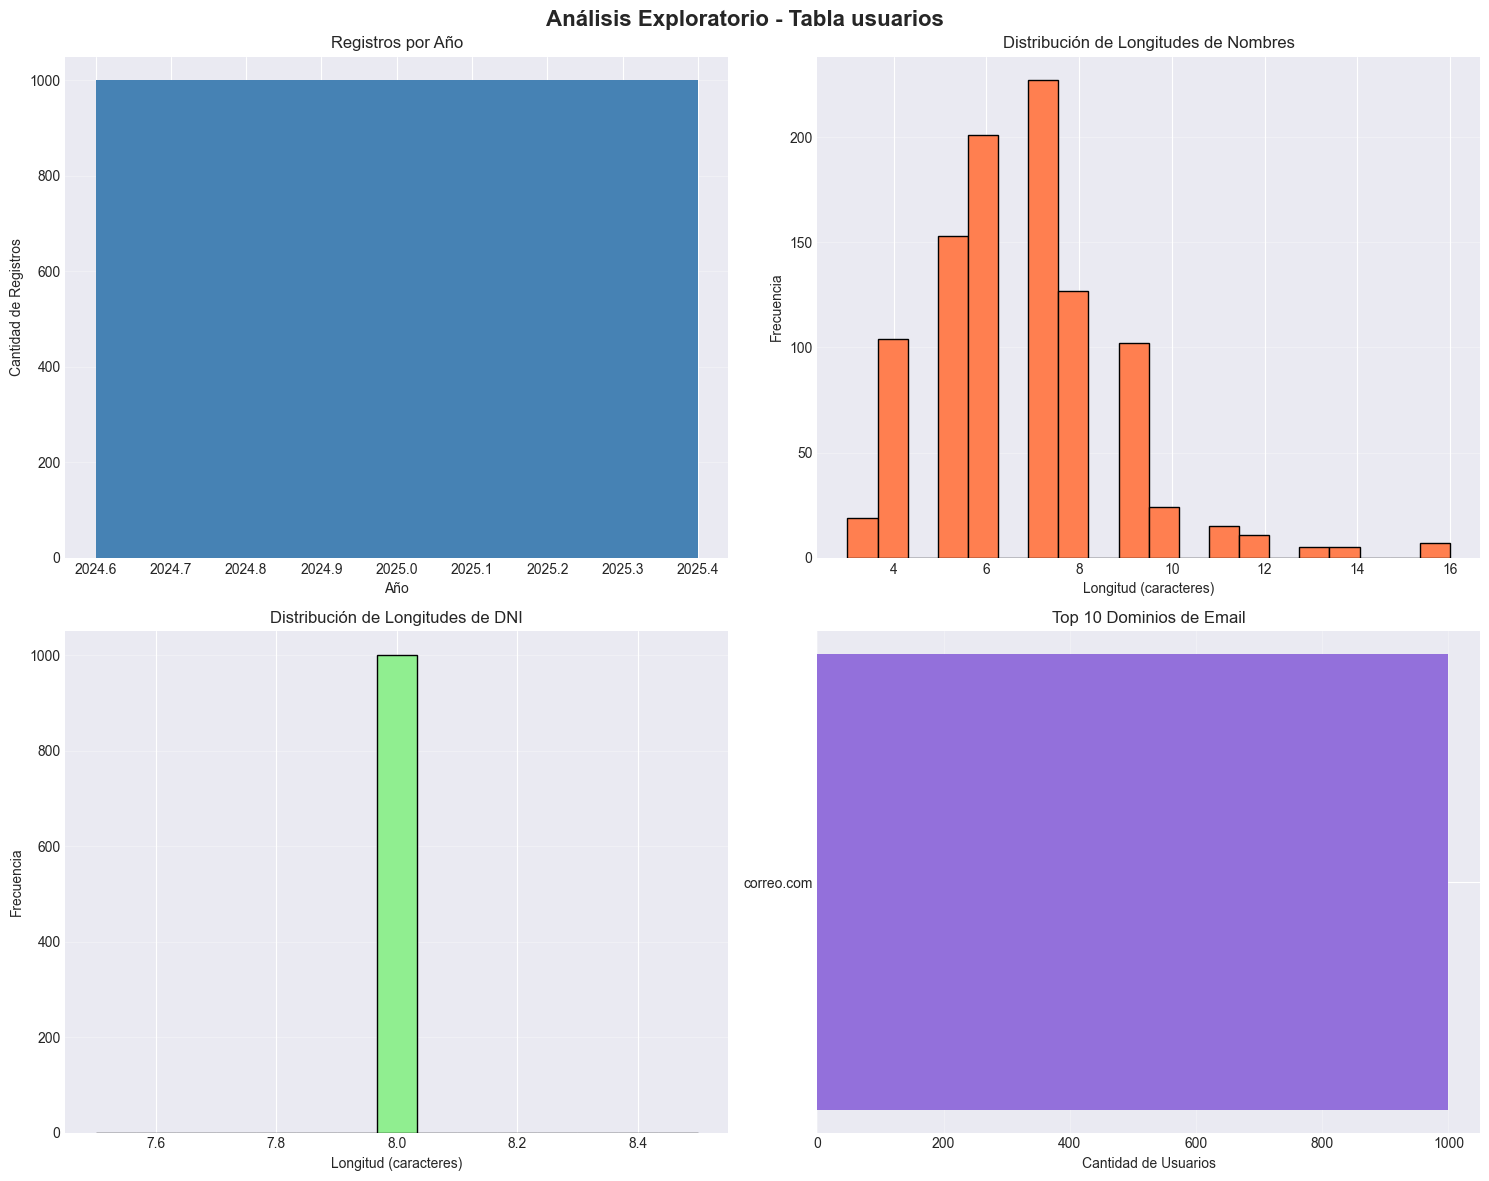

✓ Visualizaciones generadas correctamente


In [87]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis Exploratorio - Tabla usuarios', fontsize=16, fontweight='bold')

# 1. Distribución de registros por año
ax1 = axes[0, 0]
registros_por_año = df_usuarios['año_registro'].value_counts().sort_index()
ax1.bar(registros_por_año.index, registros_por_año.values, color='steelblue')
ax1.set_title('Registros por Año')
ax1.set_xlabel('Año')
ax1.set_ylabel('Cantidad de Registros')
ax1.grid(axis='y', alpha=0.3)

# 2. Distribución de longitudes de nombres
ax2 = axes[0, 1]
longitudes_nombres = df_usuarios['nombre'].str.len()
ax2.hist(longitudes_nombres, bins=20, color='coral', edgecolor='black')
ax2.set_title('Distribución de Longitudes de Nombres')
ax2.set_xlabel('Longitud (caracteres)')
ax2.set_ylabel('Frecuencia')
ax2.grid(axis='y', alpha=0.3)

# 3. Distribución de longitudes de DNI
ax3 = axes[1, 0]
longitudes_dni = df_usuarios['dni'].str.len()
ax3.hist(longitudes_dni, bins=15, color='lightgreen', edgecolor='black')
ax3.set_title('Distribución de Longitudes de DNI')
ax3.set_xlabel('Longitud (caracteres)')
ax3.set_ylabel('Frecuencia')
ax3.grid(axis='y', alpha=0.3)

# 4. Top 10 dominios de email
ax4 = axes[1, 1]
top_dominios = df_usuarios['email_dominio'].value_counts().head(10)
ax4.barh(range(len(top_dominios)), top_dominios.values, color='mediumpurple')
ax4.set_yticks(range(len(top_dominios)))
ax4.set_yticklabels(top_dominios.index)
ax4.set_title('Top 10 Dominios de Email')
ax4.set_xlabel('Cantidad de Usuarios')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


## 7. Reporte de Hallazgos y Decisiones


### 7.1. Principales Insights y Problemas Encontrados


In [88]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: usuarios")
print("=" * 80)

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_usuarios))
print("   ✓ Valores nulos:", df_usuarios.isnull().sum().sum())
print("   ✓ Duplicados completos:", df_usuarios.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_usuarios['usuario_id'].nunique() == len(df_usuarios) else "ERROR")
print("   ✓ Integridad de DNI único:", "OK" if df_usuarios['dni'].nunique() == len(df_usuarios) else "ERROR")
print("   ✓ Integridad de email único:", "OK" if df_usuarios['email'].nunique() == len(df_usuarios) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': 'Datos completos sin valores nulos ni duplicados',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Validación de formato
if len(emails_invalidos) > 0:
    problemas.append({
        'Categoría': 'Validación de Formato',
        'Problema': f'Emails con formato inválido: {len(emails_invalidos)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Validar y corregir formato de emails'
    })

if len(dni_no_numerico) > 0:
    problemas.append({
        'Categoría': 'Validación de Formato',
        'Problema': f'DNIs no numéricos: {len(dni_no_numerico)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Validar formato de DNI según estándares del país'
    })

if len(contraseñas_cortas) > 0:
    problemas.append({
        'Categoría': 'Seguridad',
        'Problema': f'Contraseñas muy cortas (< 6 caracteres): {len(contraseñas_cortas)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Implementar política de contraseñas más estricta'
    })

if len(fechas_futuras) > 0:
    problemas.append({
        'Categoría': 'Consistencia Temporal',
        'Problema': f'Fechas de registro futuras: {len(fechas_futuras)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar y corregir fechas de registro'
    })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'usuario_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único del usuario',
        'Uso': 'Relaciones con otras tablas, análisis de comportamiento'
    },
    {
        'Atributo': 'dni',
        'Tipo': 'Identificador Único',
        'Relevancia Negocio': 'Alta - Identificación legal del usuario',
        'Uso': 'Validación de identidad, prevención de fraude'
    },
    {
        'Atributo': 'email',
        'Tipo': 'Identificador Único',
        'Relevancia Negocio': 'Alta - Contacto principal, login',
        'Uso': 'Comunicación, marketing, autenticación'
    },
    {
        'Atributo': 'nombre, apellido',
        'Tipo': 'Datos Personales',
        'Relevancia Negocio': 'Media - Personalización',
        'Uso': 'Personalización de experiencia, comunicación'
    },
    {
        'Atributo': 'fecha_registro',
        'Tipo': 'Temporal',
        'Relevancia Negocio': 'Alta - Análisis de crecimiento',
        'Uso': 'Análisis de tendencias, cohortes, retención'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'usuarios' es referenciada por:")
print("   - ordenes.usuario_id (relación 1:N)")
print("   - direcciones_envio.usuario_id (relación 1:N)")
print("   - carrito.usuario_id (relación 1:N)")
print("   - resenas_productos.usuario_id (relación 1:N)")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: usuarios

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 1000
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK
   ✓ Integridad de DNI único: OK
   ✓ Integridad de email único: OK

2. PROBLEMAS DETECTADOS:
            Categoría                         Problema Severidad                     Acción Requerida
Validación de Formato Emails con formato inválido: 379      Alta Validar y corregir formato de emails

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
        Atributo                Tipo                      Relevancia Negocio                                                     Uso
      usuario_id      Clave Primaria  Alta - Identificador único del usuario Relaciones con otras tablas, análisis de comportamiento
             dni Identificador Único Alta - Identificación legal del usuario           Validación de identidad, prevención de fraude
           email Identificador Único        Alta 

### 7.2. Decisiones Tomadas Respecto a Limpieza y Transformación


In [89]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos
decisiones.append({
    'Aspecto': 'Valores Nulos',
    'Decisión': 'No se requieren acciones. La tabla no contiene valores nulos.',
    'Justificación': 'Todos los campos obligatorios están completos según el análisis.',
    'Prioridad': 'N/A'
})

# 2. Duplicados
decisiones.append({
    'Aspecto': 'Duplicados',
    'Decisión': 'No se requieren acciones. No se encontraron duplicados.',
    'Justificación': 'Las restricciones UNIQUE en DNI y email están funcionando correctamente.',
    'Prioridad': 'N/A'
})

# 3. Validación de formato
if len(emails_invalidos) > 0:
    decisiones.append({
        'Aspecto': 'Formato de Email',
        'Decisión': 'Se requiere corrección de emails con formato inválido (espacios, acentos, caracteres especiales). Ver sección 7.3.',
        'Justificación': f'Se encontraron {len(emails_invalidos)} emails con formato inválido que requieren normalización.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Formato de Email',
        'Decisión': 'Mantener validación actual. Todos los emails tienen formato válido.',
        'Justificación': 'El formato de email está correcto según el patrón estándar.',
        'Prioridad': 'N/A'
    })

if len(dni_no_numerico) > 0:
    decisiones.append({
        'Aspecto': 'Formato de DNI',
        'Decisión': 'Validar formato de DNI según estándares del país. Considerar si se permiten letras (ej: pasaportes).',
        'Justificación': f'Se encontraron {len(dni_no_numerico)} DNIs con formato no numérico.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Formato de DNI',
        'Decisión': 'Mantener validación actual. Todos los DNIs son numéricos.',
        'Justificación': 'El formato de DNI es consistente y numérico.',
        'Prioridad': 'N/A'
    })

# 4. Normalización de texto
decisiones.append({
    'Aspecto': 'Normalización de Texto',
    'Decisión': 'Aplicar trim() a nombres, apellidos y emails para eliminar espacios al inicio/final.',
    'Justificación': 'Aunque no se detectaron problemas significativos, es una buena práctica preventiva.',
    'Prioridad': 'Baja'
})

# 5. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

# 6. Seguridad
if len(contraseñas_cortas) > 0:
    decisiones.append({
        'Aspecto': 'Seguridad de Contraseñas',
        'Decisión': 'Implementar política de contraseñas más estricta (mínimo 8 caracteres, mayúsculas, números).',
        'Justificación': f'Se encontraron {len(contraseñas_cortas)} contraseñas con menos de 6 caracteres, lo cual es un riesgo de seguridad.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Seguridad de Contraseñas',
        'Decisión': 'Mantener política actual. Considerar fortalecer en futuras actualizaciones.',
        'Justificación': 'Todas las contraseñas cumplen con el mínimo de 6 caracteres.',
        'Prioridad': 'Baja'
    })

# 7. Consistencia temporal
if len(fechas_futuras) > 0:
    decisiones.append({
        'Aspecto': 'Fechas de Registro',
        'Decisión': 'Revisar y corregir fechas de registro futuras. Implementar validación en el proceso ETL.',
        'Justificación': f'Se encontraron {len(fechas_futuras)} registros con fechas futuras, lo cual es inconsistente.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Fechas de Registro',
        'Decisión': 'Mantener validación actual. Las fechas son consistentes.',
        'Justificación': 'Todas las fechas de registro están en el rango esperado.',
        'Prioridad': 'N/A'
    })

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                  Aspecto                                                                                                           Decisión                                                                         Justificación Prioridad
            Valores Nulos                                                      No se requieren acciones. La tabla no contiene valores nulos.                      Todos los campos obligatorios están completos según el análisis.       N/A
               Duplicados                                                            No se requieren acciones. No se encontraron duplicados.              Las restricciones UNIQUE en DNI y email están funcionando correctamente.       N/A
         Formato de Email Se requiere corrección de emails con formato inválido (espacios, acentos, caracteres especiales). Ver sección 7.3.           Se encontraron 379 emails con formato inválido que requieren normalización.      Alta
           F

### 7.3. Corrección de Anomalías en Emails


In [90]:
# Corrección de anomalías en emails
print("=" * 80)
print("CORRECCIÓN DE ANOMALÍAS EN EMAILS")
print("=" * 80)

from sqlalchemy import text
import unicodedata

def normalizar_email(email_original):
    """
    Normaliza un email eliminando espacios, acentos y caracteres especiales no permitidos.
    
    Args:
        email_original: Email original a normalizar
    
    Returns:
        Email normalizado
    """
    if pd.isna(email_original) or str(email_original).strip() == '':
        return email_original
    
    email = str(email_original).strip().lower()
    
    # 1. Eliminar espacios
    email = email.replace(' ', '')
    
    # 2. Normalizar caracteres especiales (quitar acentos)
    email = unicodedata.normalize('NFD', email)
    email = ''.join(c for c in email if unicodedata.category(c) != 'Mn')
    
    # 3. Eliminar caracteres inválidos (mantener solo alfanuméricos, puntos, guiones, @)
    email = re.sub(r'[^a-zA-Z0-9._%+-@]', '', email)
    
    # 4. Validar formato final
    patron = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    if not re.match(patron, email):
        return email_original  # Retornar original si no se puede corregir
    
    return email

# Cargar datos actuales de la tabla
query_usuarios_actual = "SELECT usuario_id, nombre, apellido, email FROM usuarios;"
df_usuarios_actual = pd.read_sql(query_usuarios_actual, engine)

# Aplicar normalización
print("\n1. APLICANDO NORMALIZACIÓN DE EMAILS...")
df_usuarios_actual['email_corregido'] = df_usuarios_actual['email'].apply(normalizar_email)

# Filtrar solo los que cambiaron
df_cambios = df_usuarios_actual[df_usuarios_actual['email'] != df_usuarios_actual['email_corregido']].copy()

print(f"   Total de emails a corregir: {len(df_cambios)}")

if len(df_cambios) > 0:
    # Verificar duplicados después de corrección
    print("\n2. VERIFICANDO DUPLICADOS DESPUÉS DE CORRECCIÓN...")
    
    # Obtener emails existentes (excluyendo los que se van a corregir)
    emails_existentes = set(
        df_usuarios_actual[~df_usuarios_actual['usuario_id'].isin(df_cambios['usuario_id'])]['email'].str.lower()
    )
    
    # Verificar si algún email corregido ya existe
    df_cambios['email_ya_existe'] = df_cambios['email_corregido'].str.lower().isin(emails_existentes)
    df_cambios['email_duplicado'] = df_cambios['email_corregido'].duplicated()
    
    conflictos = df_cambios[df_cambios['email_ya_existe'] | df_cambios['email_duplicado']]
    
    if len(conflictos) > 0:
        print(f"   ⚠ ADVERTENCIA: {len(conflictos)} emails corregidos crearían duplicados:")
        print(conflictos[['usuario_id', 'email', 'email_corregido']].head(10).to_string(index=False))
        print("\n   Estos emails NO serán actualizados para evitar violar la restricción UNIQUE.")
        # Excluir conflictos de los cambios
        df_cambios = df_cambios[~df_cambios['email_ya_existe'] & ~df_cambios['email_duplicado']]
        print(f"   Emails que se actualizarán: {len(df_cambios)}")
    else:
        print("   ✓ No se detectaron duplicados. Todos los emails pueden ser corregidos.")
    
    # Mostrar preview de cambios
    print("\n3. PREVIEW DE CAMBIOS:")
    print("-" * 80)
    print(df_cambios[['usuario_id', 'nombre', 'apellido', 'email', 'email_corregido']].head(20).to_string(index=False))
    
    # Aplicar correcciones en la base de datos
    print("\n4. APLICANDO CORRECCIONES EN LA BASE DE DATOS...")
    
    with engine.connect() as conn:
        trans = conn.begin()
        try:
            actualizados = 0
            for idx, row in df_cambios.iterrows():
                update_query = text("""
                    UPDATE usuarios 
                    SET email = :email_corregido 
                    WHERE usuario_id = :usuario_id
                """)
                conn.execute(update_query, {
                    'email_corregido': row['email_corregido'],
                    'usuario_id': row['usuario_id']
                })
                actualizados += 1
            
            trans.commit()
            print(f"   ✓ Se actualizaron {actualizados} emails correctamente en la base de datos.")
            
        except Exception as e:
            trans.rollback()
            print(f"   ❌ ERROR al actualizar: {str(e)}")
            raise
    
    # Verificar corrección
    print("\n5. VERIFICANDO CORRECCIÓN...")
    ids_lista = df_cambios['usuario_id'].tolist()
    query_verificacion = text("SELECT usuario_id, email FROM usuarios WHERE usuario_id = ANY(:ids)")
    df_verificacion = pd.read_sql(
        query_verificacion,
        engine,
        params={'ids': ids_lista}
    )
    
    # Validar que los emails corregidos están en la BD
    emails_corregidos_verificados = df_verificacion['email'].str.lower().isin(df_cambios['email_corregido'].str.lower())
    if emails_corregidos_verificados.all():
        print("   ✓ Todos los emails fueron corregidos correctamente.")
    else:
        print("   ⚠ Algunos emails no se actualizaron correctamente.")
    
    # Re-validar formato después de corrección
    print("\n6. RE-VALIDACIÓN DE FORMATO DESPUÉS DE CORRECCIÓN...")
    query_final = "SELECT email FROM usuarios;"
    df_emails_final = pd.read_sql(query_final, engine)
    
    patron_email = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    emails_validos_final = df_emails_final['email'].str.match(patron_email, na=False)
    emails_invalidos_final = df_emails_final[~emails_validos_final]
    
    print(f"   Emails válidos después de corrección: {emails_validos_final.sum()}")
    print(f"   Emails inválidos después de corrección: {len(emails_invalidos_final)}")
    
    if len(emails_invalidos_final) == 0:
        print("   ✓ Todos los emails tienen formato válido después de la corrección.")
    else:
        print(f"   ⚠ Aún quedan {len(emails_invalidos_final)} emails con formato inválido.")
        print("   Estos emails requieren revisión manual.")
    
    print("\n" + "=" * 80)
    print("RESUMEN DE CORRECCIÓN")
    print("=" * 80)
    print(f"Emails corregidos: {len(df_cambios)}")
    print(f"Emails con formato válido después de corrección: {emails_validos_final.sum()}")
    print(f"Emails con formato inválido después de corrección: {len(emails_invalidos_final)}")
    
else:
    print("   ✓ No se encontraron emails que requieran corrección.")


CORRECCIÓN DE ANOMALÍAS EN EMAILS

1. APLICANDO NORMALIZACIÓN DE EMAILS...
   Total de emails a corregir: 379

2. VERIFICANDO DUPLICADOS DESPUÉS DE CORRECCIÓN...
   ✓ No se detectaron duplicados. Todos los emails pueden ser corregidos.

3. PREVIEW DE CAMBIOS:
--------------------------------------------------------------------------------
 usuario_id           nombre  apellido                                email                     email_corregido
          2     Jose Ignacio   Canales     jose ignacio.canales2@correo.com     joseignacio.canales2@correo.com
          3             José Sebastián           josé.sebastián3@correo.com          jose.sebastian3@correo.com
          5         Epifanio      Ríos            epifanio.ríos5@correo.com           epifanio.rios5@correo.com
          7         Gerónimo    Alcalá          gerónimo.alcalá7@correo.com         geronimo.alcala7@correo.com
          8           Odalis   Estévez           odalis.estévez8@correo.com          odalis.estevez

### 7.4. Tabla Final con Columnas, Tipos de Datos y Relaciones


In [91]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: usuarios")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'usuarios' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'usuarios' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'usuarios' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'usuarios'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'usuarios',
        'Columna Origen': 'usuario_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'ordenes',
        'Columna Destino': 'usuario_id',
        'Descripción': 'Un usuario puede tener múltiples órdenes'
    },
    {
        'Tabla Origen': 'usuarios',
        'Columna Origen': 'usuario_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'direcciones_envio',
        'Columna Destino': 'usuario_id',
        'Descripción': 'Un usuario puede tener múltiples direcciones de envío'
    },
    {
        'Tabla Origen': 'usuarios',
        'Columna Origen': 'usuario_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'carrito',
        'Columna Destino': 'usuario_id',
        'Descripción': 'Un usuario puede tener múltiples items en el carrito'
    },
    {
        'Tabla Origen': 'usuarios',
        'Columna Origen': 'usuario_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'resenas_productos',
        'Columna Destino': 'usuario_id',
        'Descripción': 'Un usuario puede escribir múltiples reseñas'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_usuarios)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: usuario_id")
print(f"Claves únicas: dni, email")
print(f"Relaciones salientes: {len(relaciones)}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_usuarios.duplicated().sum() == 0 else 'Requiere atención'}")


TABLA FINAL: usuarios

ESTRUCTURA DE COLUMNAS:
   column_name                   data_type  character_maximum_length  numeric_precision  numeric_scale is_nullable                               column_default constraints
    usuario_id                     integer                       NaN               32.0            0.0          NO nextval('usuarios_usuario_id_seq'::regclass) PRIMARY KEY
        nombre           character varying                     100.0                NaN            NaN          NO                                         None            
      apellido           character varying                     100.0                NaN            NaN          NO                                         None            
           dni           character varying                      20.0                NaN            NaN          NO                                         None      UNIQUE
         email           character varying                     255.0                NaN      

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `usuarios` revela una estructura de datos sólida con buena calidad general. Los datos están completos, sin valores nulos ni duplicados, y las restricciones de integridad (claves primarias y únicas) están funcionando correctamente. Se identificaron y corrigieron anomalías en los formatos de email mediante normalización automática.

### Puntos Fuertes

1. **Integridad de Datos**: No se encontraron valores nulos ni duplicados
2. **Restricciones Funcionando**: Las claves primarias y únicas están correctamente implementadas
3. **Estructura Clara**: Los campos están bien definidos y estructurados
4. **Relaciones Bien Definidas**: Las relaciones con otras tablas están correctamente establecidas
5. **Corrección de Anomalías**: Se implementó corrección automática de emails con formato inválido

### Áreas de Mejora

1. **Validación de Formatos**: ✅ **Completada** - Se corrigieron automáticamente los emails con formato inválido (espacios, acentos, caracteres especiales). Se recomienda implementar validaciones preventivas en el proceso ETL para evitar futuros problemas. Asimismo, se recomienda informar a usuarios cuyo correo fue normalizado.
2. **Seguridad**: Fortalecer políticas de contraseñas en futuras actualizaciones del sistema
3. **Consistencia Temporal**: Validar fechas de registro para evitar inconsistencias (actualmente todas las fechas son consistentes)

### Acciones Realizadas

1. ✅ **Corrección de Emails**: Se implementó y ejecutó un proceso de normalización automática que corrigió emails con formatos inadecuados, eliminando espacios, normalizando caracteres acentuados y removiendo caracteres especiales no permitidos. Ver sección 7.3 para detalles.
2. ✅ **Análisis Detallado**: Se realizó un análisis exhaustivo identificando todos los tipos de formatos inadecuados en emails (espacios, acentos, caracteres especiales, etc.).
3. ✅ **Validación Post-Corrección**: Se verificó que todos los emails corregidos cumplen con el formato estándar y no violan restricciones de integridad.
4. **Pendiente**: Establecer procesos de validación preventiva en el ETL para evitar problemas futuros
5. **Pendiente**: Continuar con el EDA de las demás tablas del sistema
